In [1]:
%load_ext autoreload
%autoreload 2

#per la riproducibilità
%env CUBLAS_WORKSPACE_CONFIG=":4096:8"

import os
import itertools
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from IPython.display import Markdown as md
from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx
from networkx import stochastic_block_model


from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits, new_parameters_linears
from train import Trainer, Dataset
from embedding import Embedding
from config_valid import Config, TrainingMode
import experiments
from experiments import Experiments, experiment_node_embedding, all_seeds
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, plot_metrics, plot_node_emb_1D, plot_node_emb_nD, scatter_node_emb, 
                        plot_graph_emb_1D, plot_graph_emb_nD, plot_data_degree_sequence, plot_corr_epoch, plot_ripetizioni_stesso_trial, 
                        plot_onlyloss_ripetizioni_stesso_trial,plot_onlyloss_ripetizioni_stesso_trial_superimposed, Data2Plot)
from plot_model import plot_model
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect


import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats
from sklearn.metrics import log_loss

import pickle 
from plt_parameters import init_params, get_colors_to_cycle_rainbow8, get_colors_to_cycle_rainbowN
init_params()
rootsave = Path("output_plots/")

env: CUBLAS_WORKSPACE_CONFIG=":4096:8"


# Studio embedding 0 epoche (freezed GCN) $\sim$ training con Linear

## Erdos Renyi

In [2]:
config_file = "configurations/1layer_freezed.yml"
c = Config(config_file)
c.conf['graph_dataset']['list_p'] = [0.2, 0.01]    
c.conf['model']['neurons_last_linear'] = [10, 10, 2]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train(parallel=True)

In [3]:
embedding_class = xp.embedding()

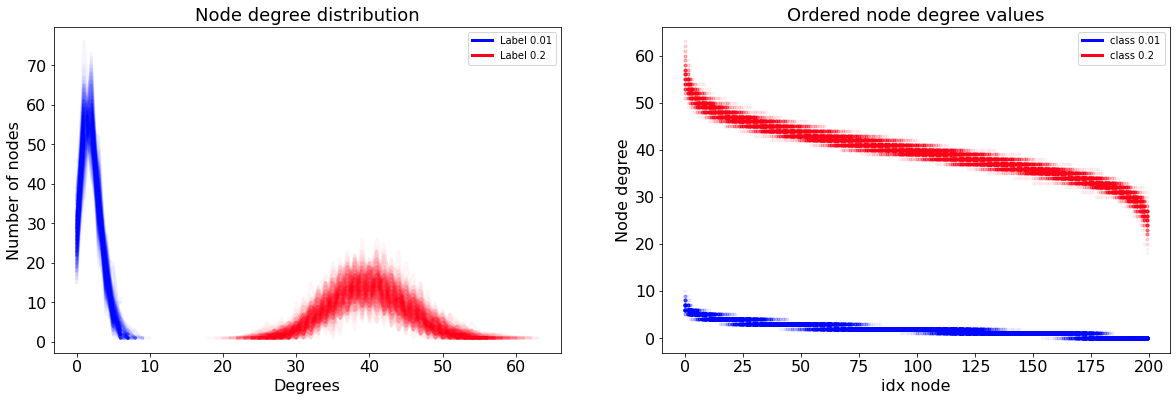

Plotting 2D or n>=2 embeddings...


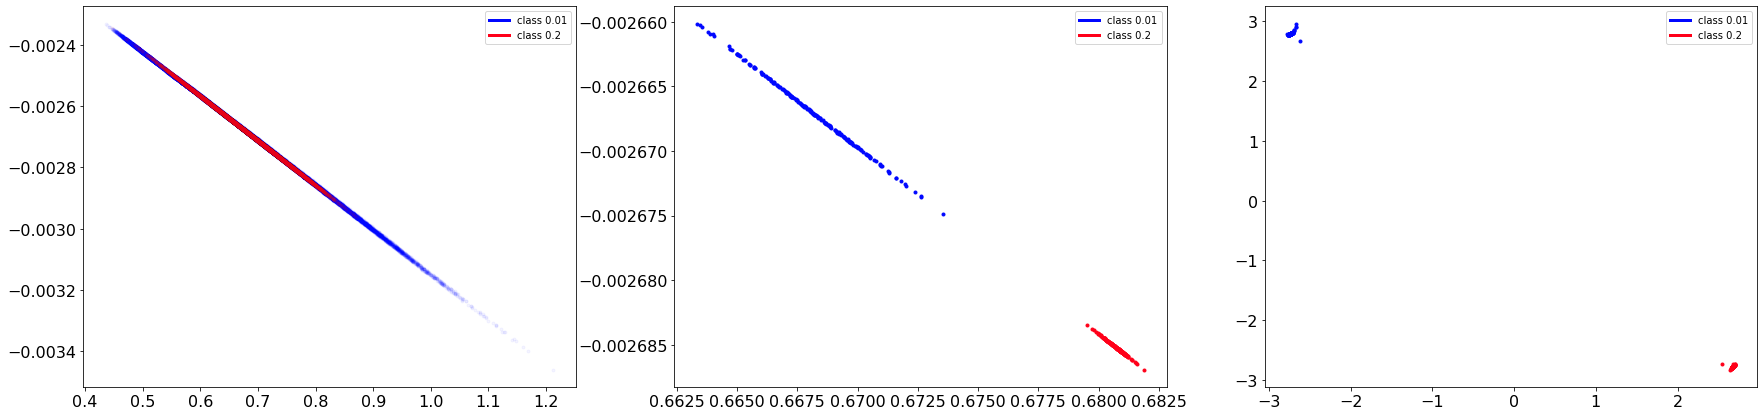

In [7]:
plot_data_degree_sequence(embedding_class.emb_perclass, log=False)
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
trainmode = xp.trainer.config_class.modo
plot_metrics(embedding_class, num_emb_neurons, trainmode)

In [16]:
experiments.graph_embedding_per_epoch = xp.trainer.graph_embedding_per_epoch
experiments.node_embedding_per_epoch = xp.trainer.node_embedding_per_epoch
experiments.dataset = xp.trainer.dataset
experiments.loss_list = xp.trainer.test_loss_list
experiments.exp_config = xp.trainer.config_class
experiments.dataset_type = xp.trainer.gg.type
my_log_list = my_log_lista=list(range(20)) + list(range(20,100,5)) + list(range(100,250, 20)) + list(range(250, 500, 50))
len(my_log_list)

49

In [17]:
nomefile = xp.make_video(skip=1, fromfiles=True, custom_list=my_log_list)

scatter_exp[0.2_0.01]_nodi200_grafi400_percent0.7_mode1_layers[1_32_32_2]_finaldenseTrue_freezedFalse


<img src="scatter_exp[0.2_0.01]_nodi200_grafi400_percent0.7_mode1_layers[1_32_32_2]_finaldenseTrue_freezedFalse.gif" width="1200" align="center">

### dim = 1

In [2]:
config_file = "configurations/1layer_freezed.yml"
c = Config(config_file)
c.conf['graph_dataset']['list_p'] = [0.2, 0.01]    
c.conf['model']['GCNneurons_per_layer'] = [1, 32, 32, 1]
c.conf['model']['neurons_last_linear'] = [10, 10, 2]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train(parallel=True)

Generating dataset...
Mean connectivity for each node: 39.826 p=0.2
Mean connectivity for each node: 1.993 p=0.01
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 47.61it/s]


Tempo impiegato: 8.443427324295044


100%|███████████████████████████████████████████████████████████████████| 500/500 [01:15<00:00,  6.65it/s]

test accuracy finale: 1.0


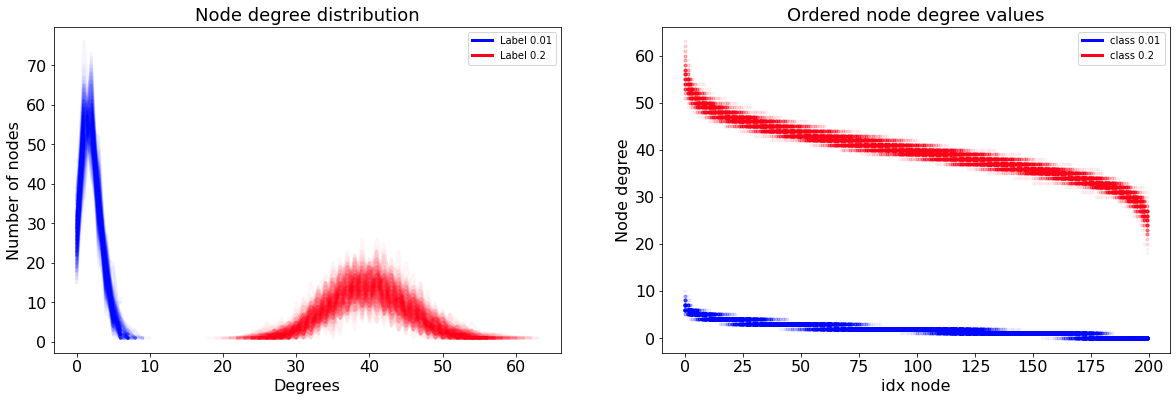

Plotting 1D embeddings...


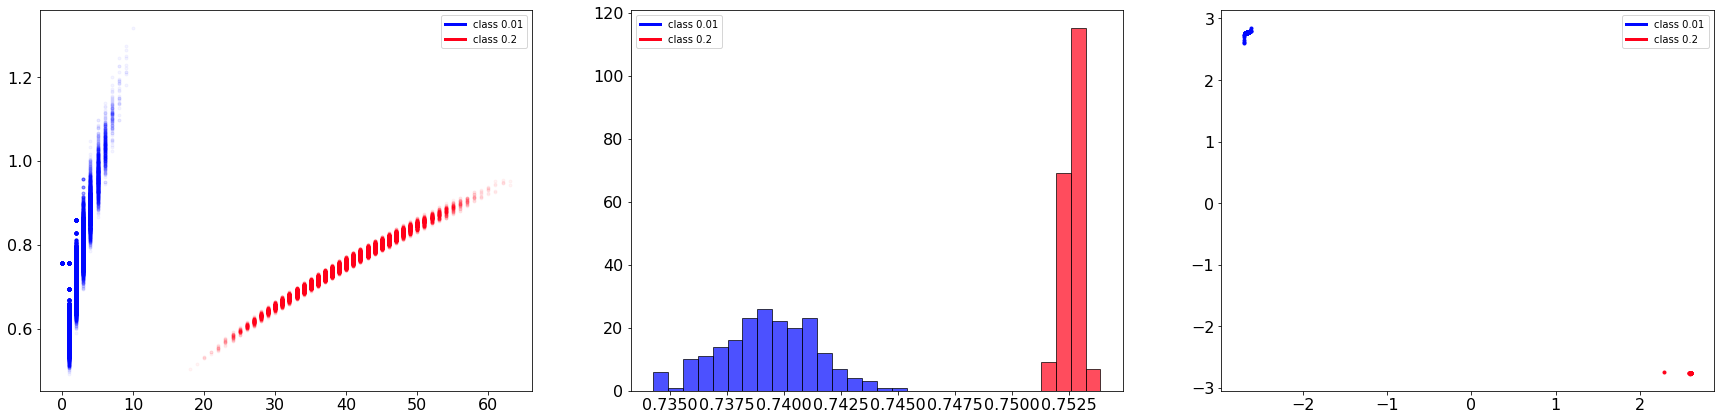

In [44]:
embedding_class = xp.embedding()
plot_data_degree_sequence(embedding_class.emb_perclass, log=False)
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
trainmode = xp.trainer.config_class.modo
plot_metrics(embedding_class, num_emb_neurons, trainmode)

In [45]:
experiments.graph_embedding_per_epoch = xp.trainer.graph_embedding_per_epoch
experiments.node_embedding_per_epoch = xp.trainer.node_embedding_per_epoch
experiments.dataset = xp.trainer.dataset
experiments.loss_list = xp.trainer.test_loss_list
experiments.exp_config = xp.trainer.config_class
experiments.dataset_type = xp.trainer.gg.type
experiments.embedding_dimension = num_emb_neurons
my_log_list = my_log_lista=list(range(20)) + list(range(20,100,5)) + list(range(100,250, 20)) + list(range(250, 500, 50))
len(my_log_list)
nomefile = xp.make_video(skip=1, fromfiles=True, custom_list=my_log_list)

scatter_exp[0.2_0.01]_nodi200_grafi400_percent0.7_mode1_layers[1_32_32_1]_finaldenseTrue_freezedFalse


In [46]:
md(f'<img src={nomefile}.gif width="1200" align="center">')

<img src=scatter_exp[0.2_0.01]_nodi200_grafi400_percent0.7_mode1_layers[1_32_32_1]_finaldenseTrue_freezedFalse.gif width="1200" align="center">

<img src="scatter_exp[0.2_0.01]_nodi200_grafi400_percent0.7_mode1_layers[1_32_32_2]_finaldenseTrue_freezedFalse.gif" width="1200" align="center">

### Più classi

In [74]:
config_file = "configurations/1layer_freezed.yml"
c = Config(config_file)
c.conf['graph_dataset']['ERmodel'] = False
c.conf['graph_dataset']['confmodel'] = True
c.conf['model']['GCNneurons_per_layer'] = [1, 32, 32, 1]
c.conf['model']['neurons_last_linear'] = [10, 10, 2]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train(parallel=True)
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 59.697 p=0.3
Mean connectivity for each node: 39.742 p=0.2
Mean connectivity for each node: 19.914 p=0.1
Mean connectivity for each node: 9.948 p=0.05
Mean connectivity for each node: 1.999 p=0.01
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.90it/s]


Tempo impiegato: 25.836163997650146


100%|███████████████████████████████████████████████████████████████████| 500/500 [03:14<00:00,  2.57it/s]


test accuracy finale: 0.23333333333333334


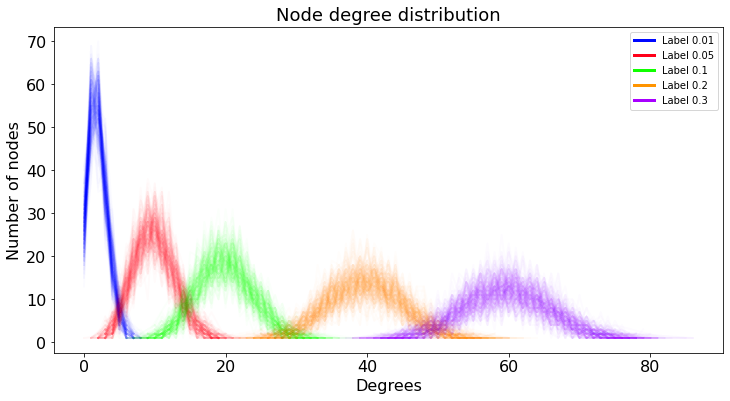

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


calcolo l'overlap


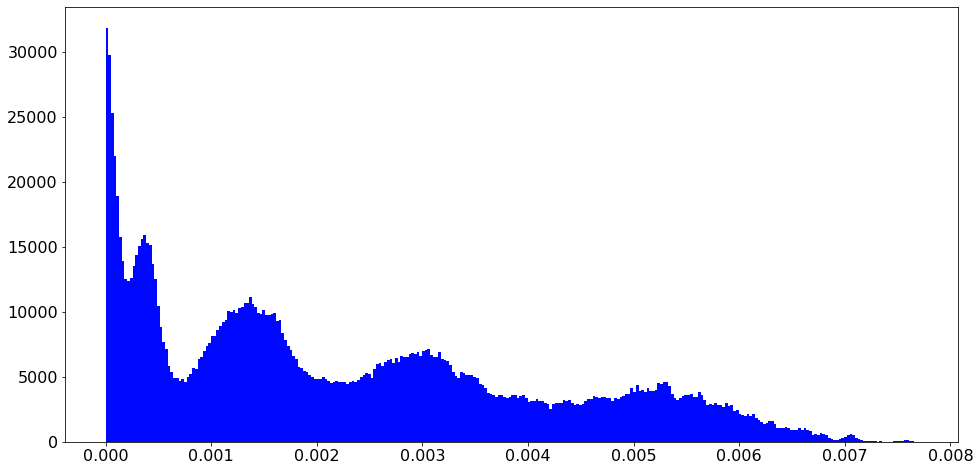

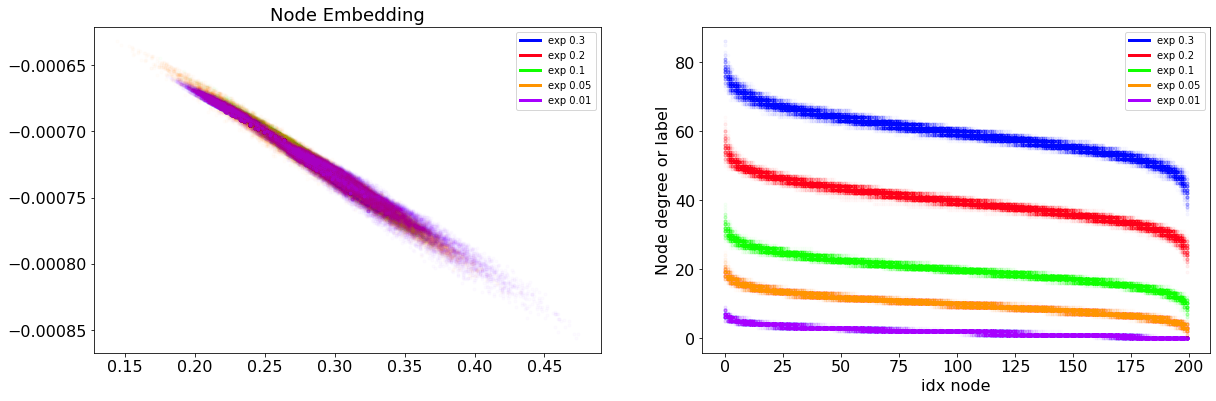

In [86]:
plot_data_degree_sequence(embedding_class.emb_perclass, log=False)
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons, xp.trainer.config_class.modo)

In [128]:
gpe = xp.trainer.graph_embedding_per_epoch
npe = xp.trainer.node_embedding_per_epoch
out_array = xp.trainer.output_per_epoch

In [256]:
j = 4 #482
embepoch = Embedding(gpe[j], npe[j], xp.trainer.dataset, xp.trainer.config_class, out_array[j])
embepoch.get_emb_per_graph()  # riempie node_emb_pergraph
embepoch.separate_embedding_by_classes()

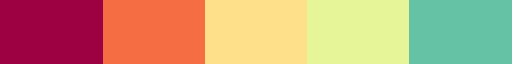

In [278]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from plt_parameters import get_colors_to_cycle_sequential
mpl.colors.ListedColormap(get_colors_to_cycle_sequential(5), name='from_list', N=None)

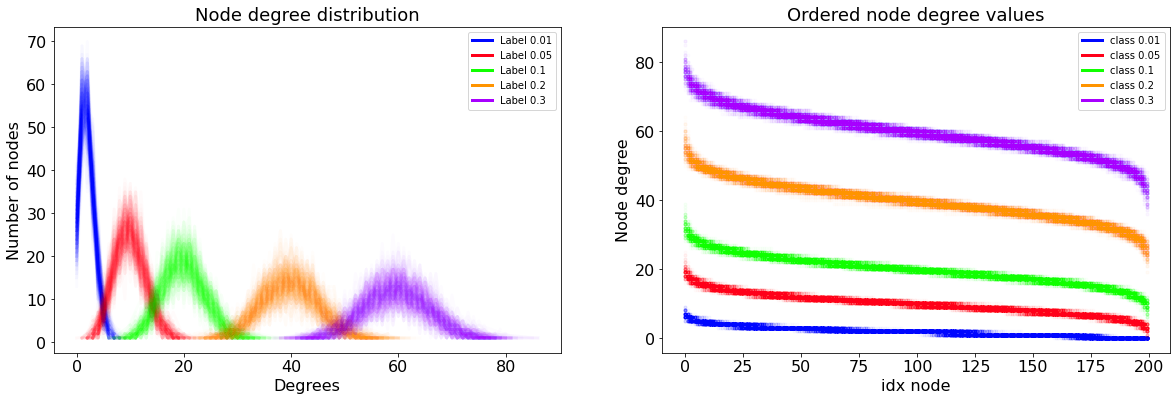

Plotting 2D or n>=2 embeddings...
1000 1000


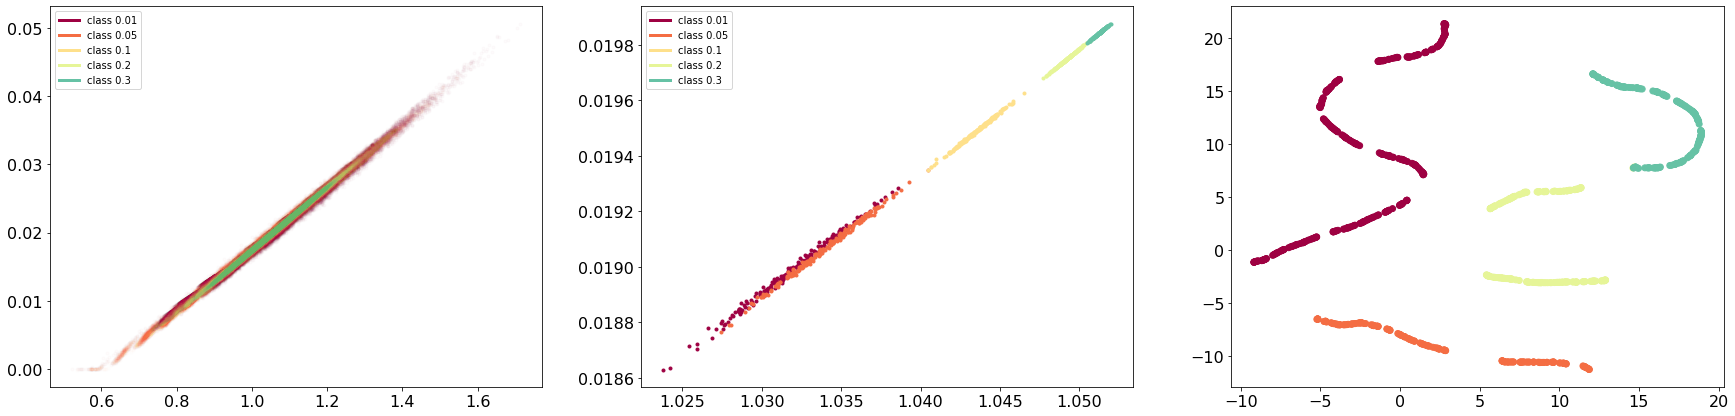

In [287]:
plot_data_degree_sequence(embepoch.emb_perclass, log=False)
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
trainmode = xp.trainer.config_class.modo
plot_metrics(embepoch, num_emb_neurons, trainmode)

## Power law

In [ ]:
config_file = "configurations/1layer_freezed.yml"
c = Config(config_file)
c.conf['graph_dataset']['ERmodel'] = False
c.conf['graph_dataset']['confmodel'] = True
c.conf['graph_dataset']['Num_nodes'] = [100]*10
c.conf['model']['GCNneurons_per_layer'] = [1, 32, 32, 1]
c.conf['model']['neurons_last_linear'] = [10, 10, 10]
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train(parallel=True)
embedding_class = xp.embedding()

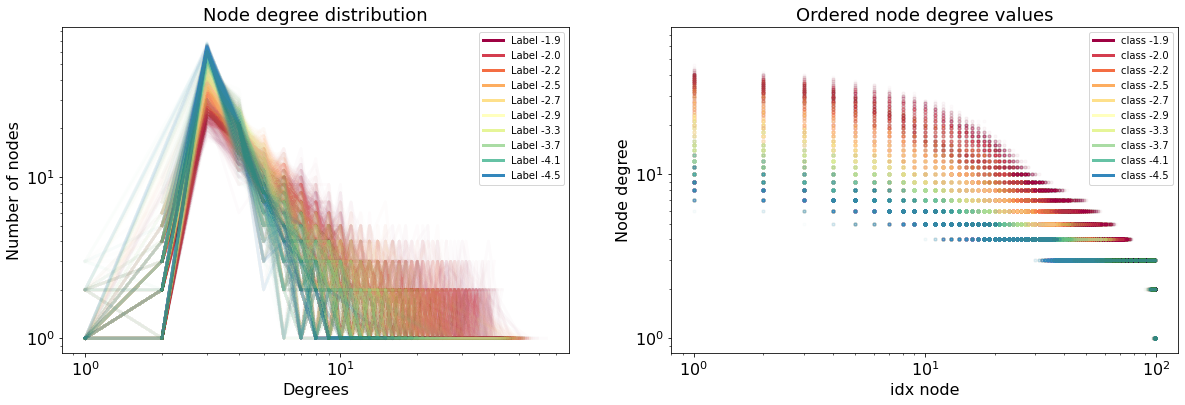

Plotting 1D embeddings...


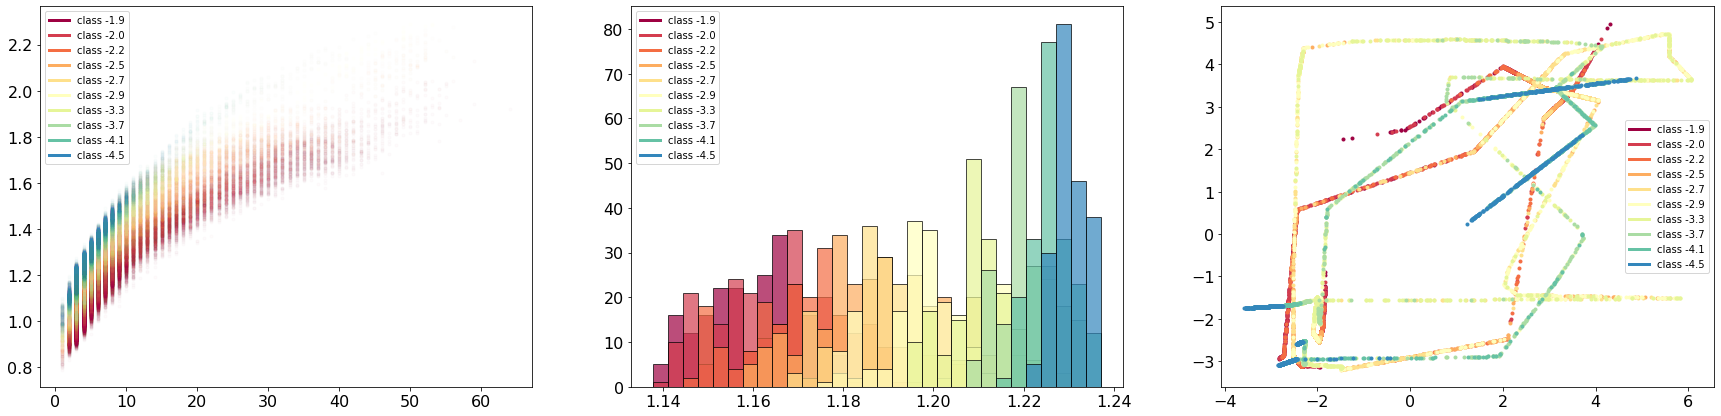

In [4]:
#embedding_class = xp.embedding()
plot_data_degree_sequence(embedding_class.emb_perclass, sequential_colors=True, log=True)
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
trainmode = xp.trainer.config_class.modo
plot_metrics(embedding_class, num_emb_neurons, trainmode, sequential_colors=True)

In [9]:
experiments.graph_embedding_per_epoch = xp.trainer.graph_embedding_per_epoch
experiments.node_embedding_per_epoch = xp.trainer.node_embedding_per_epoch
experiments.dataset = xp.trainer.dataset
experiments.loss_list = xp.trainer.test_loss_list
experiments.exp_config = xp.trainer.config_class
experiments.dataset_type = xp.trainer.gg.type
experiments.embedding_dimension = num_emb_neurons
my_log_list = my_log_lista=list(range(20)) + list(range(20,100,5)) + list(range(100,250, 20)) + list(range(250, 500, 50))
len(my_log_list)
nomefile = xp.make_video(skip=1, fromfiles=True, custom_list=my_log_list, seq_colors=True)

scatter_exp10_nodi100_grafi400_percent0.7_mode1_layers[1_32_32_1]_finaldenseTrue_freezedFalse


In [10]:
md(f'<img src={nomefile}.gif width="1200" align="center">')

<img src=scatter_exp10_nodi100_grafi400_percent0.7_mode1_layers[1_32_32_1]_finaldenseTrue_freezedFalse.gif width="1200" align="center">

### dim = 2  non ce la fa dopo 10k epoche   $\rightarrow$ perché 200 nodi erano pochi
dim = 32 non ce la comunque
450 nodi, 40 grafi, dim 2

In [2]:
config_file = "configurations/1layer_freezed.yml"
c = Config(config_file)
c.conf['graph_dataset']['ERmodel'] = False
c.conf['graph_dataset']['confmodel'] = True
c.conf['graph_dataset']['Num_nodes'] = [450]*7
c.conf['graph_dataset']['Num_grafi_per_tipo'] = 40
c.conf['graph_dataset']['list_exponents'] = [-2.5, -2.7, -2.9, -3.3, -3.7, -4.1, -4.5]
c.conf['model']['GCNneurons_per_layer'] = [1, 64, 32, 2]
c.conf['model']['neurons_last_linear'] = [16, 16, 7]
#c.conf['training']['epochs'] = 20000
c.conf['training']['learning_rate'] = 0.005
c.conf['training']['every_epoch_embedding'] = True
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train(parallel=True)
embedding_class = xp.embedding()

Generating dataset...
Dataset generated
Loading Dataset...


100%|██████████████████████████████████████████████████████████████████████| 280/280 [00:05<00:00, 52.53it/s]


Tempo impiegato: 5.387095928192139


100%|████████████████████████████████████████████████████████████████████| 2500/2500 [06:42<00:00,  6.21it/s]


test accuracy finale: 1.0


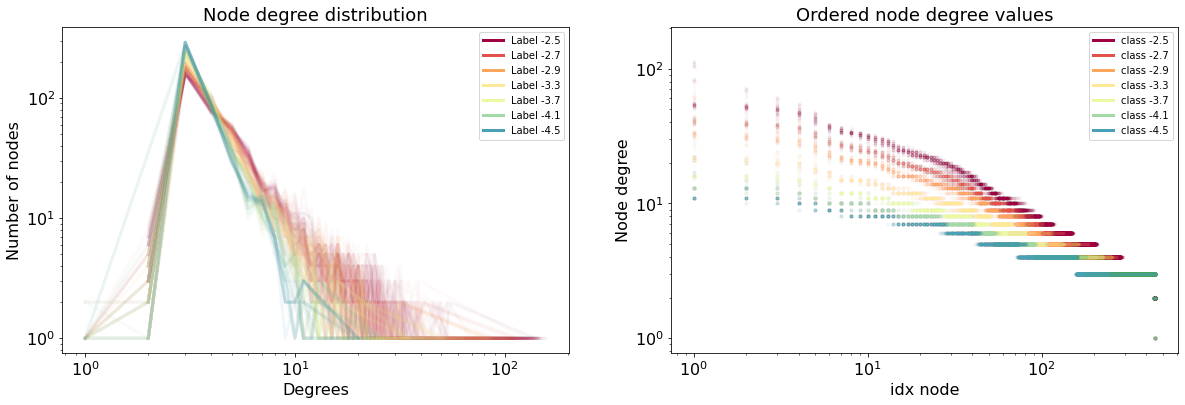

Plotting 2D or n>=2 embeddings...


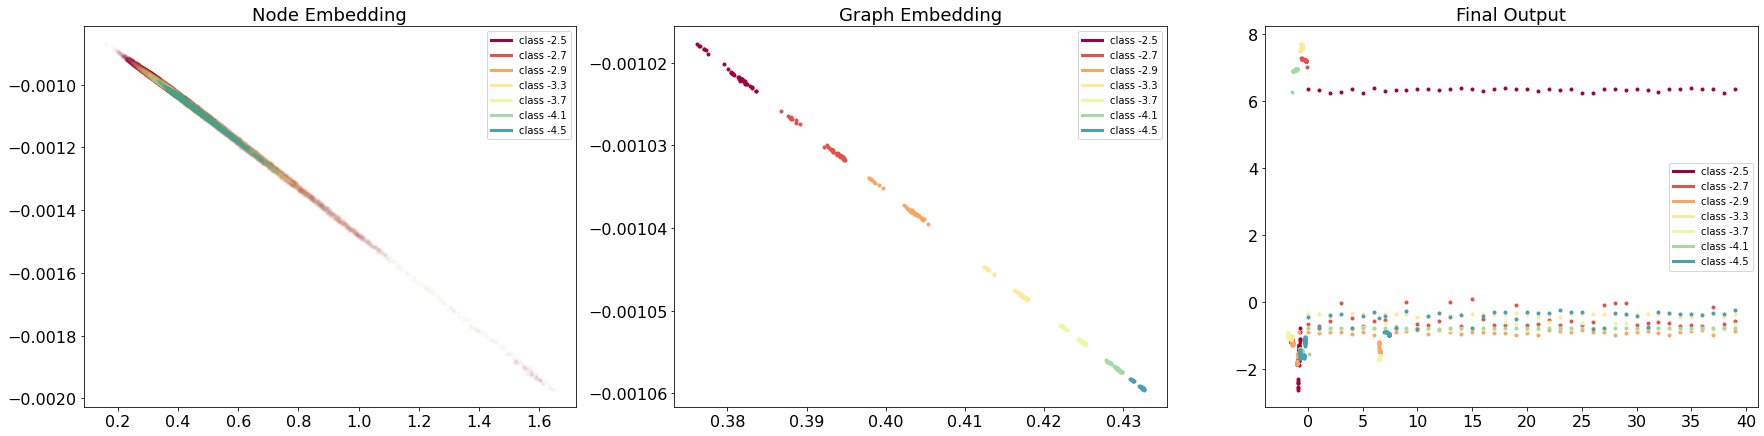

In [4]:
plot_data_degree_sequence(embedding_class.emb_perclass, sequential_colors=True, log=True)
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
trainmode = xp.trainer.config_class.modo
plot_metrics(embedding_class, num_emb_neurons, trainmode, sequential_colors=True)

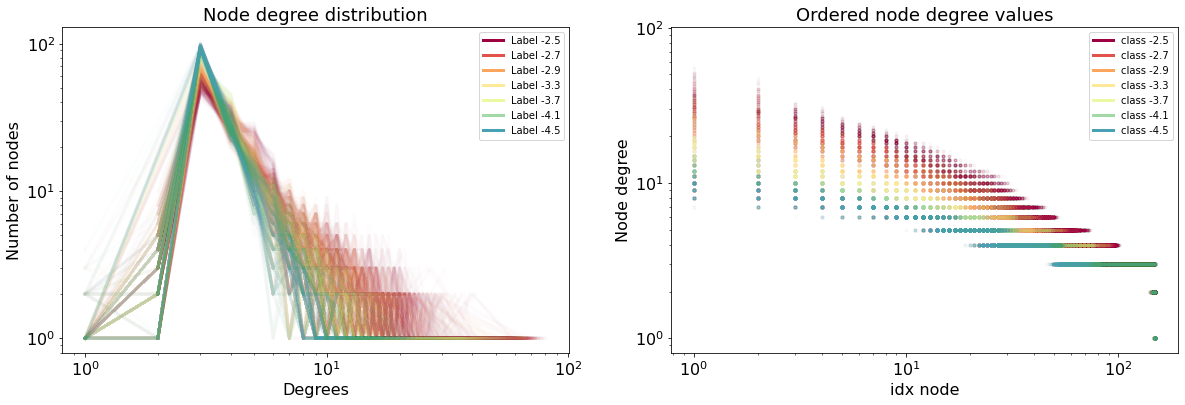

Plotting 2D or n>=2 embeddings...


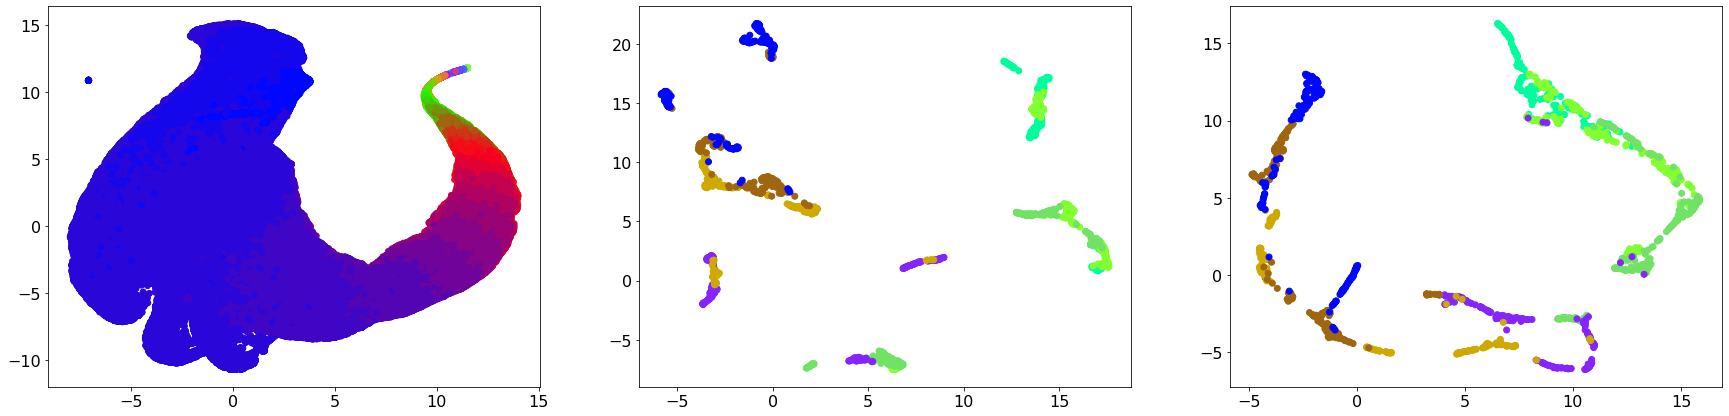

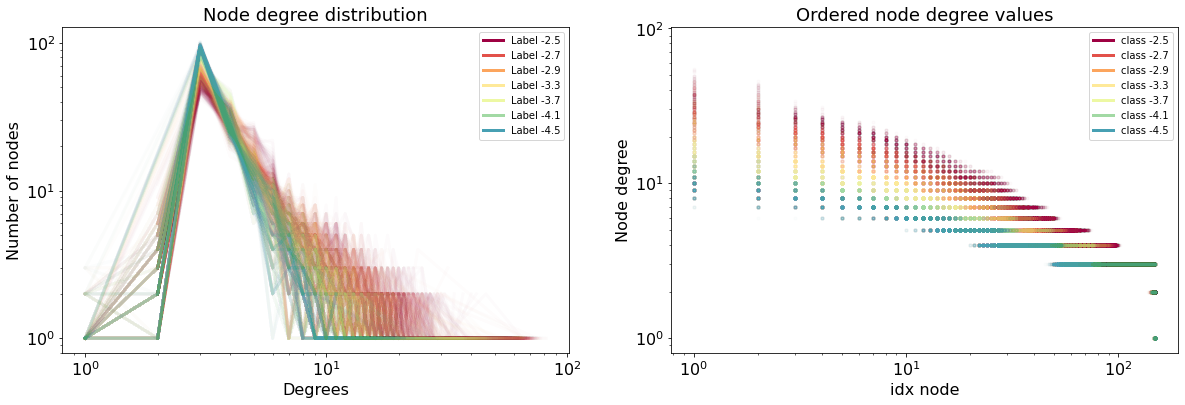

Plotting 2D or n>=2 embeddings...


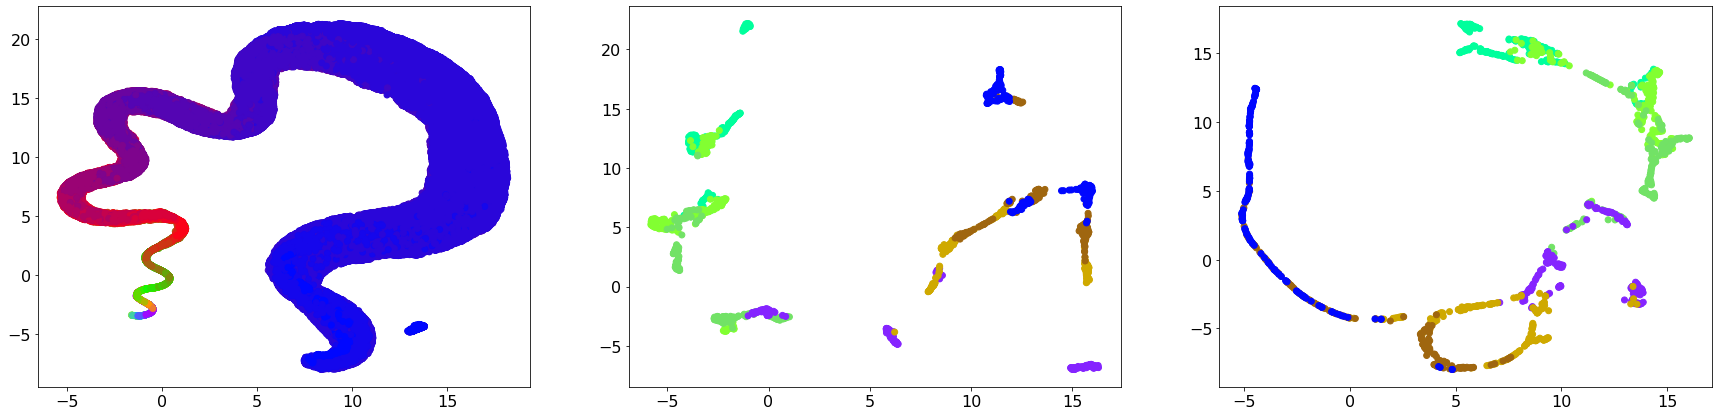

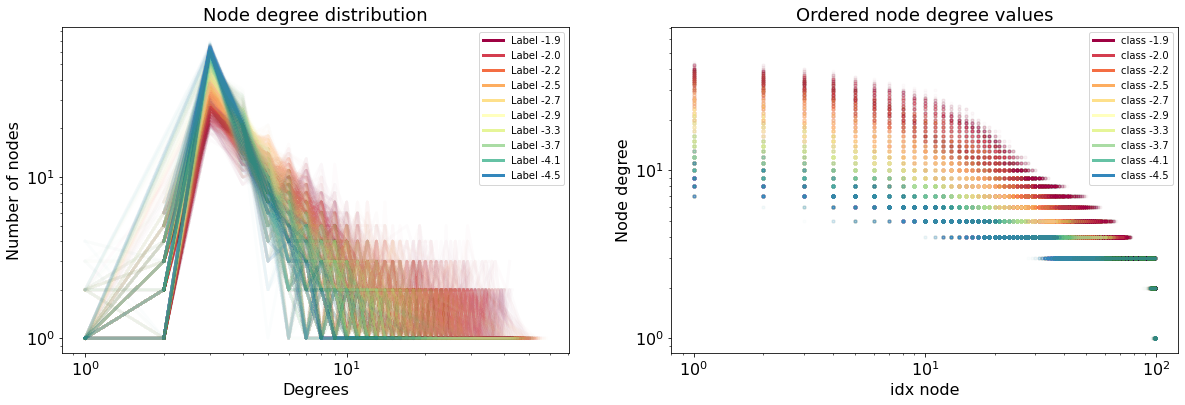

Plotting 2D or n>=2 embeddings...


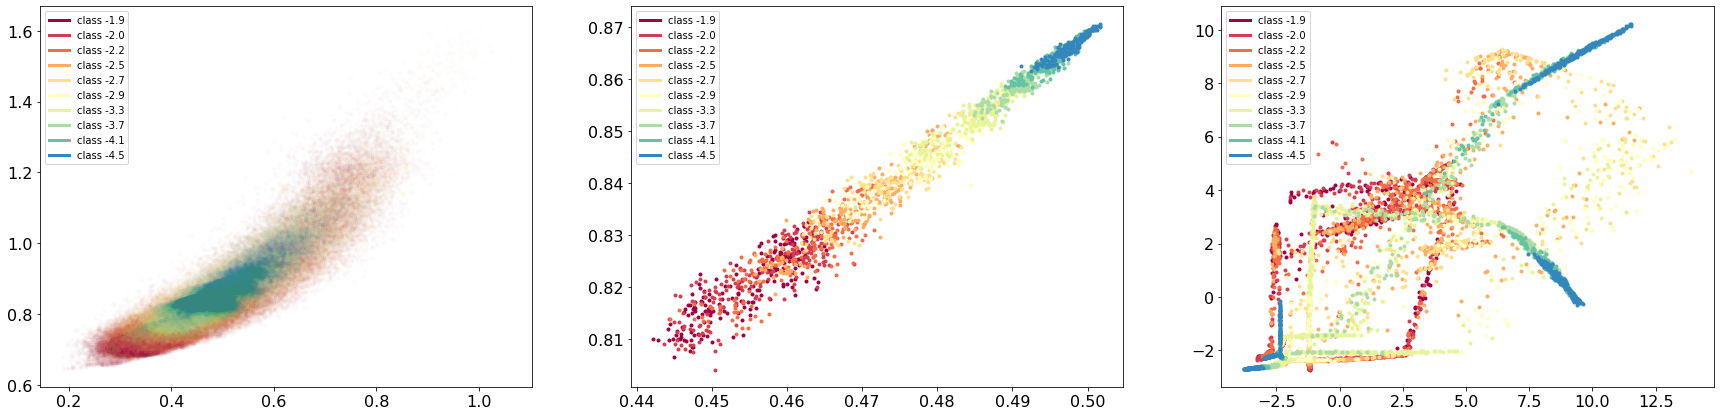

In [3]:
xp.trainer.last_epoch

2499

In [8]:
xp.trainer.output_per_epoch

[]

In [7]:
experiments.graph_embedding_per_epoch = xp.trainer.graph_embedding_per_epoch
experiments.node_embedding_per_epoch = xp.trainer.node_embedding_per_epoch
experiments.dataset = xp.trainer.dataset
experiments.loss_list = xp.trainer.test_loss_list
experiments.exp_config = xp.trainer.config_class
experiments.dataset_type = xp.trainer.gg.type
experiments.embedding_dimension = num_emb_neurons
my_log_list = my_log_lista=list(range(20)) + list(range(20,100,4)) + list(range(100,500, 15)) + list(range(500, 2500, 40))
len(my_log_list)
nomefile = xp.make_video(skip=1, fromfiles=True, custom_list=my_log_list, seq_colors=True)

scatter_exp7_nodi450_grafi80_percent0.7_mode1_layers[1_64_32_2]_finaldenseTrue_freezedFalse


In [5]:
md(f'<img src={nomefile}.gif width="1200" align="center">')

<img src=scatter_exp10_nodi100_grafi400_percent0.7_mode1_layers[1_32_32_2]_finaldenseTrue_freezedFalse.gif width="1200" align="center">

In [73]:
md(f'<img src={nomefile}.gif width="1200" align="center">')

<img src=scatter_exp7_nodi450_grafi80_percent0.7_mode1_layers[1_64_32_2]_finaldenseTrue_freezedFalse.gif width="1200" align="center">

In [72]:
nomefile

'scatter_exp7_nodi450_grafi80_percent0.7_mode1_layers[1_64_32_2]_finaldenseTrue_freezedFalse'

In [9]:
import umap.aligned_umap

In [37]:
outputs = np.array(xp.trainer.output_per_epoch)
slices = outputs[my_log_list]
len(slices), slices[0].shape

(117, (280, 7))

In [43]:
stride = 30
window_length=200
#slices = [outputs[stride * i:min(len(outputs), stride * i + window_length)] for i in range(10)]
#relation_dict = {i+stride:i for i in range(window_length-stride)}
relation_dict = {i:i for i in range(len(slices))}
relation_dicts = [relation_dict.copy() for i in range(len(slices) - 1)]

In [44]:
aligned_mapper = umap.AlignedUMAP().fit(slices, relations=relation_dicts)

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/umap/umap_.py:919: RuntimeWarning: overflow encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]


In [57]:
labels = embedding_class.get_unique_class_labels()
allgraph_class_labels = [emb.scalar_label  for emb_per_graph in embedding_class.emb_perclass for emb in emb_per_graph]

In [70]:
d = {v:i for i,v in enumerate(np.unique(np.array(allgraph_class_labels)))}
integers_allgraph_class_labels = [d[k] for k in allgraph_class_labels]

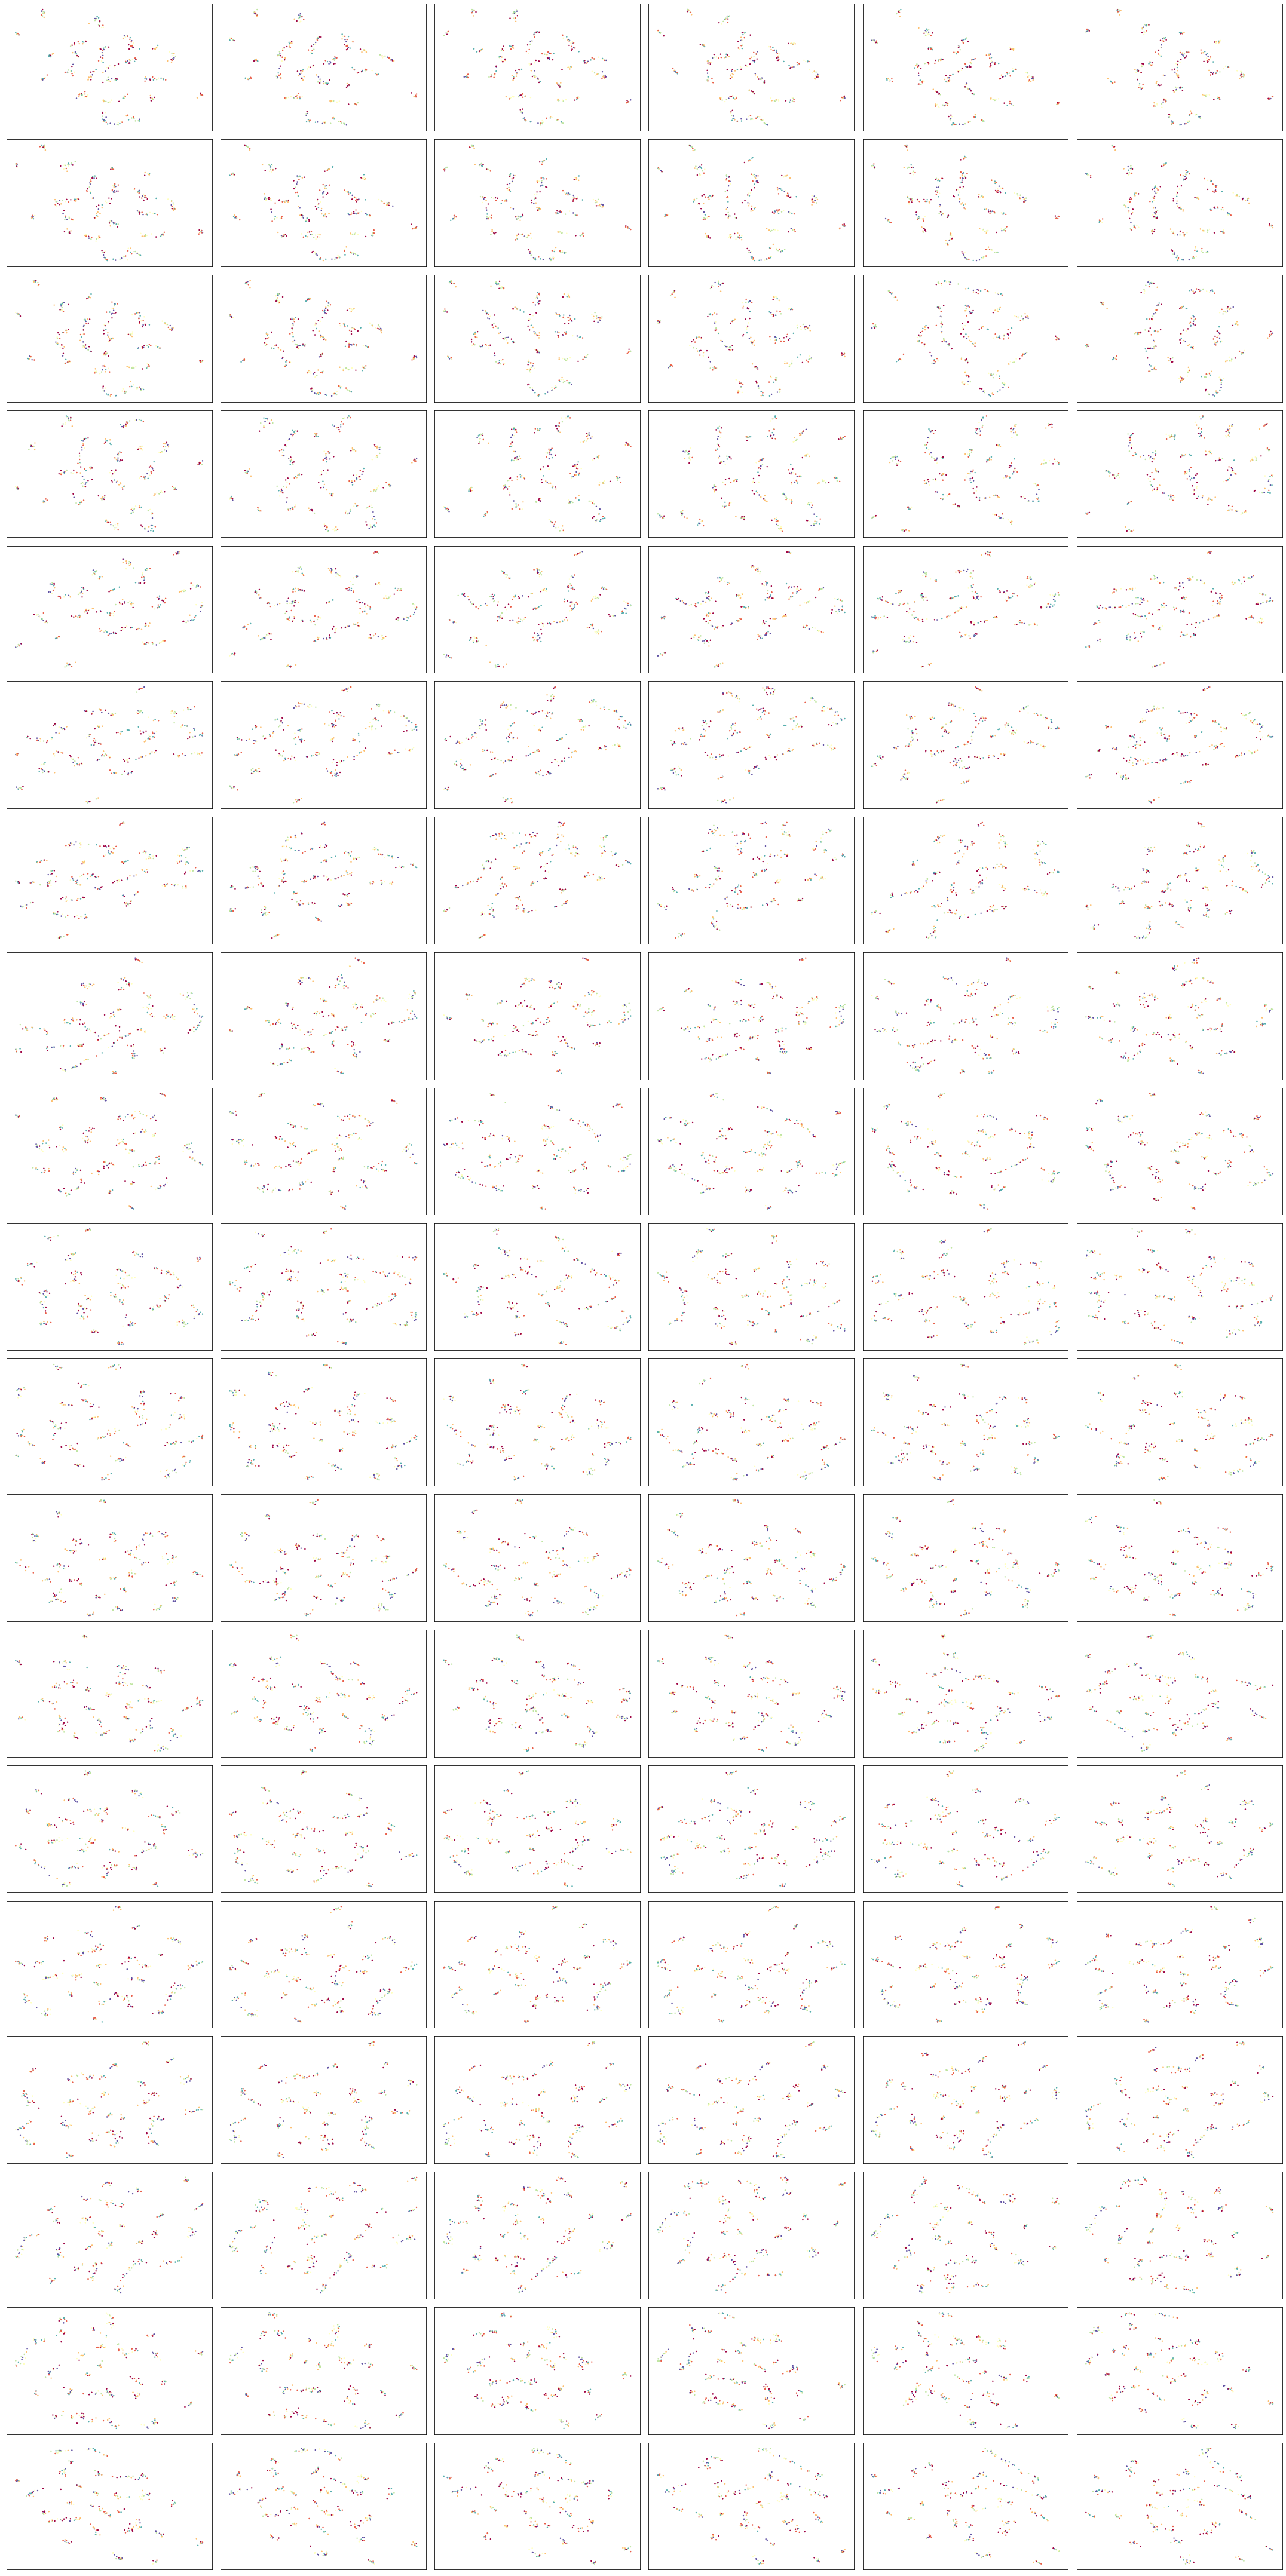

In [71]:
fig, axs = plt.subplots(len(slices)//6, 6, figsize=(30, 60))
#ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    #current_target = ordered_target[150 * i:min(ordered_target.shape[0], 150 * i + 400)]
    # plot degli embedding di aligned UMAP
    ax.scatter(*aligned_mapper.embeddings_[i].T, s=2, c=integers_allgraph_class_labels, cmap="Spectral")
    #ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()